In [12]:
import os
import cv2
import numpy as np
import pandas as pd

TRAIN_DIR = 'train'
TEST_DIR = 'test'

train_images = [ os.path.join(TRAIN_DIR, f) for f in os.listdir(TRAIN_DIR) ]
test_images = [ os.path.join(TEST_DIR, f) for f in os.listdir(TEST_DIR) ]

CHANNELS = 3
ROWS = 224
COLS = 224

# train_images = train_images[:640]
# test_images = test_images[:640]

def read_image(path):
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def load_images(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)
    for i, img in enumerate(images):
        data[i] = read_image(img).T
    return data
    
train = load_images(train_images)
test = load_images(test_images)

In [13]:
from sklearn.preprocessing import OneHotEncoder
def onehot(x): return np.array(OneHotEncoder().fit_transform(x.reshape(-1,1)).todense())

labels = np.array([ 'dog' in i for i in train_images ], dtype=np.uint8)
labels = onehot(labels)

In [14]:
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))
print("Labels shape: {}".format(train.shape))

Train shape: (25000, 3, 224, 224)
Test shape: (12500, 3, 224, 224)
Labels shape: (25000, 3, 224, 224)


In [51]:
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D

# Mean of each channel as provided by VGG researchers
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

def ConvBlock(layers, model, filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, 3, 3, activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    return model

model = VGG_16()

In [52]:
model.load_weights('vgg16.h5')

In [53]:
from keras.optimizers import Adam

model.pop()
model.add(Dense(2, activation='softmax'))
for layer in model.layers[:-3]:
    layer.trainable=False
model.compile(optimizer=Adam(lr=0.001),
    loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_11 (Lambda)               (None, 3, 224, 224)   0           lambda_input_11[0][0]            
____________________________________________________________________________________________________
zeropadding2d_131 (ZeroPadding2D)(None, 3, 226, 226)   0           lambda_11[0][0]                  
____________________________________________________________________________________________________
convolution2d_131 (Convolution2D)(None, 64, 224, 224)  0           zeropadding2d_131[0][0]          
____________________________________________________________________________________________________
zeropadding2d_132 (ZeroPadding2D)(None, 64, 226, 226)  0           convolution2d_131[0][0]          
___________________________________________________________________________________________

In [54]:
from keras.callbacks import Callback, EarlyStopping

nb_epoch = 1
batch_size = 64

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def run_catdog():
    history = LossHistory()
    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    predictions = model.predict(test, verbose=1)
    return predictions, history

predictions, history = run_catdog()

Train on 18750 samples, validate on 6250 samples
Epoch 1/1
 3072/18750 [===>..........................] - ETA: 408s - loss: 2.4259 - acc: 0.8268

KeyboardInterrupt: 

In [20]:
model.save_weights('finetune1.h5')

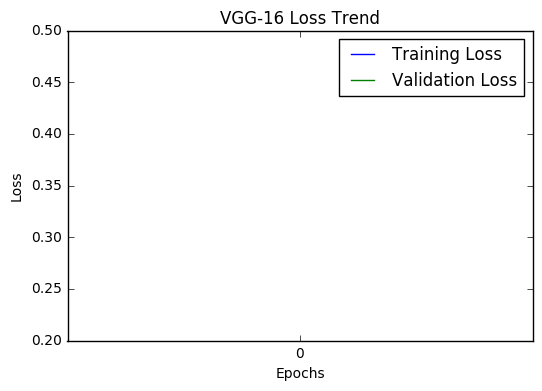

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline 

loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()